# Plus proches voisins en grande dimension - correction

La méthodes des [plus proches voisins](https://fr.wikipedia.org/wiki/Recherche_des_plus_proches_voisins) est un algorithme assez simple qui devient très lent en grande dimension. Ce notebook propose un moyen d'aller plus vite (ACP) mais en perdant un peu en performance. 

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## Q1 : k-nn : mesurer la performance

In [ ]:
import time
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

def what_to_measure(n, n_features, n_classes=3, n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute"):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(datax, datay)
    t1 = time.clock()
    y = model.predict(datax)
    t2 = time.clock()
    return t2 - t1, y

In [ ]:
dt, y = what_to_measure(2000, 10)
dt

0.08857036416351902

### dimension

In [ ]:
x = []
y = []
ys = []
for nf in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    x.append(nf)
    dt, _ = what_to_measure(5000, n_features=nf)
    y.append(dt)
    if nf <= 100:
        dt2, _ = what_to_measure(5000, n_features=nf, algorithm="ball_tree")
    else:
        dt2 = None
    ys.append(dt2)
    print("nf={0} dt={1} dt2={2}".format(nf, dt, dt2))

nf=10 dt=0.5873510075840613 dt2=0.4646710542170922
nf=20 dt=0.6074920207502146 dt2=0.7714100486991811
nf=50 dt=0.6564365553344942 dt2=1.6188338344685462
nf=100 dt=0.7027262782503385 dt2=4.378059798842742
nf=200 dt=0.5979730196862647 dt2=None
nf=500 dt=0.8006753967304121 dt2=None
nf=1000 dt=0.9721063046641802 dt2=None
nf=2000 dt=1.2413097386946674 dt2=None
nf=5000 dt=2.4931281069098077 dt2=None
nf=10000 dt=4.519591680483927 dt2=None


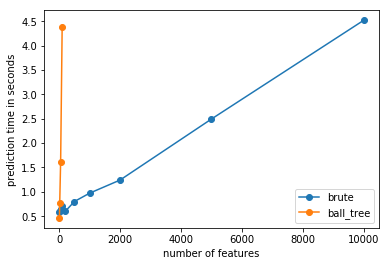

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.plot(x, ys, "o-", label="ball_tree")
ax.set_xlabel("number of features")
ax.set_ylabel("prediction time in seconds")
ax.legend()

### observations

In [ ]:
x = []
y = []
ys = []
for nobs in [1000, 2000, 5000, 10000, 12000, 15000, 17000, 20000]:
    x.append(nobs)
    dt, _ = what_to_measure(nobs, n_features=200)
    y.append(dt)
    if nobs <= 5000:
        dt2, _ = what_to_measure(nobs, n_features=200, algorithm="ball_tree")
    else:
        dt2 = None
    ys.append(dt2)
    print("nobs={0} dt={1} dt2={2}".format(nobs, dt, dt2))

nobs=1000 dt=0.04281199864260543 dt2=0.3112272854590401
nobs=2000 dt=0.10341005027942174 dt2=1.2617928749120892
nobs=5000 dt=0.6151605548714087 dt2=9.747505286907312
nobs=10000 dt=2.538724497314206 dt2=None
nobs=12000 dt=3.9736723274994574 dt2=None
nobs=15000 dt=6.333187950789579 dt2=None
nobs=17000 dt=7.835518614694024 dt2=None
nobs=20000 dt=15.668280491914516 dt2=None


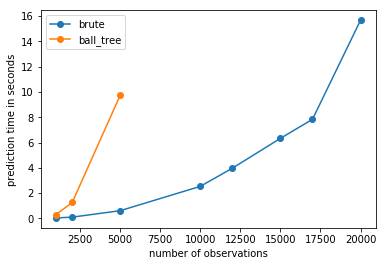

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.plot(x, ys, "o-", label="ball_tree")
ax.set_xlabel("number of observations")
ax.set_ylabel("prediction time in seconds")
ax.legend()

## Q2 : k-nn avec sparse features

On recommence cette mesure de temps mais en créant des jeux de données [sparses](https://fr.wikipedia.org/wiki/Matrice_creuse).

## Q3 : Imaginez une façon d'aller plus vite ?

Le coût d'un algorithme des plus proches voisins est linéaire selon la dimension car la majeure partie du temps est passé dans la fonction de distance et que celle-ci est linéaire. L'idée est d'utiliser une [ACP](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales) sur des ensembles aléatoires de features, d'apprendre un classifieur sur chaque ensemble, puis de combiner les voisins.